In [1]:
!pip install mediapipe numpy
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [1]:
!pip install --upgrade --force-reinstall numpy mediapipe tensorflow

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached jax-0.5.3-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.5.3-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached prot

In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import scipy
import os
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


In [3]:
# Google Drive setup
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/mlp"

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [5]:
def save_video_reps(video_name, reps_data, save_dir='processed_data'):
    """
    Save rep data for a single video to a .npz file.

    Args:
        video_name (str): Name of the video file
        reps_data (list): List of numpy arrays containing rep data
        save_dir (str): Directory to save the .npz files
    """
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, video_name.replace('.mp4', '.npz'))
    save_dict = {f'rep_{i}': rep for i, rep in enumerate(reps_data)}
    np.savez_compressed(save_path, **save_dict)

def process_videos_directory(data_dir, save_dir='processed_data'):
    """
    Process all videos in directory, skipping those that already have .npz files.

    Args:
        data_dir (str): Directory containing videos
        save_dir (str): Directory to save processed data

    Returns:
        dict: Dictionary of processed videos and their rep data
    """
    os.makedirs(save_dir, exist_ok=True)
    all_sets_data = {}

    for file in os.listdir(data_dir):
        if file.endswith('.mp4'):
            npz_path = os.path.join(save_dir, file.replace('.mp4', '.npz'))

            if os.path.exists(npz_path):
                print(f"Skipping {file} - already processed")
                continue

            print(f"Processing {file}...")
            video_path = os.path.join(data_dir, file)
            set_data = extract_rep_joint_data(video_path)
            all_sets_data[file] = set_data

            # Save the processed data
            save_video_reps(file, set_data, save_dir)
            print(f"Found and saved {len(set_data)} reps for {file}")

    return all_sets_data

def save_existing_reps_data(all_reps_data, save_dir='processed_data'):
    """
    Save any rep data currently in memory that hasn't been saved yet.

    Args:
        all_reps_data (dict): Dictionary mapping video names to rep data
        save_dir (str): Directory to save processed data
    """
    os.makedirs(save_dir, exist_ok=True)

    for video_name, set_data in all_reps_data.items():
        npz_path = os.path.join(save_dir, video_name.replace('.mp4', '.npz'))
        if not os.path.exists(npz_path):
            print(f"Saving data for {video_name}...")
            save_video_reps(video_name, set_data, save_dir)

import numpy as np

def load_all_processed_data(processed_dir='data_to_model_npz'):
    """
    Load all processed rep data from .npz files in directory.

    Returns:
        dict: Dictionary mapping video names to a list of rep arrays.
              Each rep array should ideally have shape (timesteps, 4).
    """
    all_sets_data = {}

    for file in os.listdir(processed_dir):
        if file.endswith('.npz'):
            video_name = file.replace('.npz', '.mp4')
            npz_path = os.path.join(processed_dir, file)

            loaded = np.load(npz_path)
            rep_keys = [k for k in loaded.files if k.startswith('rep_')]
            rep_keys.sort(key=lambda x: int(x.split('_')[1])) # Sort based on rep number

            reps = [loaded[key] for key in rep_keys]

            # Print shape of each rep
            for i, rep in enumerate(reps):
                print(f"Rep {i} shape for {video_name}: {rep.shape}")

            all_sets_data[video_name] = reps
            print(f"Loaded {len(reps)} reps from {video_name}")

    return all_sets_data


In [6]:
import numpy as np

def prepare_rep_for_lstm_quantiles(rep_data, fps=30, num_quantiles=10):
    """
    Prepares a single repetition's joint data for LSTM input by:
    1. Computing ROM (Range of Motion) - angle between wrist-elbow and elbow-shoulder lines
    2. Computing velocities for elbow and wrist
    3. Normalizing coordinates relative to the shoulder
    4. Extracting values at specific quantiles

    Args:
        rep_data (np.ndarray): Array of shape (timesteps, 6) containing
                              [shoulder_x, shoulder_y, elbow_x, elbow_y, wrist_x, wrist_y]
        fps (int): Frames per second of the video
        num_quantiles (int): Number of quantiles to extract (default: 10)

    Returns:
        np.ndarray: Processed features of shape (num_quantiles, n_features)
    """

    # 1. Calculate ROM (using shoulder, elbow, and wrist)
    v1 = rep_data[:, 4:6] - rep_data[:, 2:4]  # Wrist to Elbow
    v2 = rep_data[:, 2:4] - rep_data[:, 0:2]  # Elbow to Shoulder
    dot_product = np.sum(v1 * v2, axis=1)
    mag_v1 = np.sqrt(np.sum(v1**2, axis=1))
    mag_v2 = np.sqrt(np.sum(v2**2, axis=1))
    mag_v1[mag_v1 == 0] = 1e-8
    mag_v2[mag_v2 == 0] = 1e-8
    rom_rad = np.arccos(dot_product / (mag_v1 * mag_v2))
    rom_percentage = (rom_rad - np.min(rom_rad)) / (np.max(rom_rad) - np.min(rom_rad))

    # 2. Calculate velocities (change in position per frame)
    dt = 1 / fps
    elbow_velocity = np.sqrt(np.gradient(rep_data[:, 2])**2 + np.gradient(rep_data[:, 3])**2) / dt
    wrist_velocity = np.sqrt(np.gradient(rep_data[:, 4])**2 + np.gradient(rep_data[:, 5])**2) / dt

    # 3. Normalizing coordinates: Shoulder starts at (0, 0)
    normalized_coords = rep_data.copy()
    shoulder_origin = rep_data[0, 0:2]  # Get initial shoulder position

    # Translate elbow and wrist relative to shoulder origin
    elbow_coords = rep_data[:, 2:4] - shoulder_origin
    wrist_coords = rep_data[:, 4:6] - shoulder_origin

    # Combine elbow and wrist coordinates into normalized_coords
    normalized_coords = np.column_stack([elbow_coords, wrist_coords])



    # 4. Extract values at quantiles
    quantile_indices = np.round(np.linspace(0, len(rep_data) - 1, num_quantiles)).astype(int)

    # Extract values at those indices
    selected_coords = normalized_coords[quantile_indices]
    selected_elbow_velocity = elbow_velocity[quantile_indices]
    selected_wrist_velocity = wrist_velocity[quantile_indices]
    selected_rom_percentage = rom_percentage[quantile_indices]

    # Combine selected features
    features = np.column_stack([
        selected_coords,
        selected_elbow_velocity,
        selected_wrist_velocity,
        selected_rom_percentage
    ])

    return features

In [128]:
import numpy as np

def find_smallest_rep_shape(all_sets):
  """Finds the smallest rep shape in the given data.

  Args:
    all_sets: A dictionary mapping video names to a list of rep arrays.

  Returns:
    A tuple containing the smallest rep shape and the corresponding video name.
  """
  smallest_shape = (float('inf'), float('inf'))  # Initialize with infinity
  smallest_video = None

  for video_name, reps_list in all_sets.items():
    for rep in reps_list:
      rep_shape = rep.shape
      if rep_shape[0] < smallest_shape[0]:  # Compare based on the first dimension (timesteps)
        smallest_shape = rep_shape
        smallest_video = video_name

  return smallest_shape, smallest_video

# Assuming 'all_sets' is already loaded
all_sets = load_all_processed_data("./data_to_model_npz")
smallest_shape, smallest_video = find_smallest_rep_shape(all_sets)

print(f"Smallest rep shape: {smallest_shape}")
print(f"Video with smallest rep: {smallest_video}")

Rep 0 shape for 5_r.mp4: (179, 6)
Rep 1 shape for 5_r.mp4: (146, 6)
Rep 2 shape for 5_r.mp4: (141, 6)
Rep 3 shape for 5_r.mp4: (143, 6)
Rep 4 shape for 5_r.mp4: (148, 6)
Rep 5 shape for 5_r.mp4: (148, 6)
Rep 6 shape for 5_r.mp4: (146, 6)
Rep 7 shape for 5_r.mp4: (155, 6)
Rep 8 shape for 5_r.mp4: (155, 6)
Rep 9 shape for 5_r.mp4: (156, 6)
Rep 10 shape for 5_r.mp4: (155, 6)
Rep 11 shape for 5_r.mp4: (160, 6)
Rep 12 shape for 5_r.mp4: (161, 6)
Rep 13 shape for 5_r.mp4: (169, 6)
Rep 14 shape for 5_r.mp4: (182, 6)
Loaded 15 reps from 5_r.mp4
Rep 0 shape for IMG_5721.mp4: (71, 6)
Rep 1 shape for IMG_5721.mp4: (83, 6)
Rep 2 shape for IMG_5721.mp4: (88, 6)
Rep 3 shape for IMG_5721.mp4: (84, 6)
Rep 4 shape for IMG_5721.mp4: (82, 6)
Rep 5 shape for IMG_5721.mp4: (80, 6)
Rep 6 shape for IMG_5721.mp4: (84, 6)
Rep 7 shape for IMG_5721.mp4: (84, 6)
Rep 8 shape for IMG_5721.mp4: (94, 6)
Rep 9 shape for IMG_5721.mp4: (78, 6)
Rep 10 shape for IMG_5721.mp4: (81, 6)
Rep 11 shape for IMG_5721.mp4: (85, 6)

In [ ]:
import pandas as pd

# Get the first video name from all_sets
first_video_name = list(all_sets.keys())[0]

# Get the first repetition from that video
first_rep = all_sets[first_video_name][0]

# Define column names based on the data structure
column_names = ['Shoulder X', 'Shoulder Y', 'Elbow X', 'Elbow Y', 'Wrist X', 'Wrist Y']

# Create a DataFrame
df = pd.DataFrame(first_rep)

# Display the DataFrame
print(f"Video: {first_video_name}, Rep: 0")
display(df)

Video: IMG_5774_cut.mp4, Rep: 0


,0,1,2,3,4,5
0,317.652555,543.758774,333.847475,739.208298,404.989529,899.868851
1,322.196496,545.987740,332.692323,742.308350,407.576895,899.921570
2,324.854071,546.058044,330.518060,742.225418,408.492880,894.416199
3,324.179270,547.287712,321.884651,742.117081,410.838461,885.399399
4,324.221456,548.036423,321.455390,742.070770,414.930310,878.047409
5,325.746346,547.942429,316.618381,741.992950,418.431902,868.751526
6,325.669677,549.782715,313.004758,748.223495,445.363169,868.004608
7,322.503061,552.525024,307.697268,748.345032,443.741226,852.071152
8,321.163394,557.475471,309.241018,756.104584,461.703358,842.692108
9,317.704139,559.389267,308.805213,758.077621,461.798286,827.773438


In [129]:
# 1) Prepare your data:
all_sets_list = list(all_sets.values())


In [130]:
import numpy as np
from scipy.interpolate import interp1d

def augment_time_series(data, speed_range=(0.9, 1.1), noise_std=0.01):
    """
    Augment a 9 x T time series by applying a random speed shift and jitter.

    Parameters:
        data (np.ndarray): Input array of shape (9, T)
        speed_range (tuple): Range for random speed multiplier (e.g., 0.9 to 1.1)
        noise_std (float): Standard deviation of Gaussian noise to add.

    Returns:
        np.ndarray: Augmented data of shape (9, T_augmented), where T_augmented is close to T.
    """
    num_channels, T = data.shape  # num_channels is now 9

    # 1. Time Warping (Speed Shifting)
    speed_factor = np.random.uniform(*speed_range)
    original_indices = np.arange(T)
    new_length = int(T / speed_factor)
    new_indices = np.linspace(0, T - 1, new_length)

    warped_data = np.zeros((num_channels, new_length))
    for i in range(num_channels):
        interp_func = interp1d(original_indices, data[i, :], kind='linear', fill_value="extrapolate")
        warped_data[i, :] = interp_func(new_indices)

    # Re-interpolate back to T timesteps
    re_indices = np.linspace(0, new_length - 1, T)
    warped_data_fixed = np.zeros((num_channels, T))
    for i in range(num_channels):
        interp_func = interp1d(np.arange(new_length), warped_data[i, :], kind='linear', fill_value="extrapolate")
        warped_data_fixed[i, :] = interp_func(re_indices)

    # 2. Jittering (Noise Injection)
    noise = np.random.normal(0, noise_std, size=warped_data_fixed.shape)
    augmented_data = warped_data_fixed + noise

    return augmented_data

In [14]:
print(list(all_sets.keys()))
print(len(list(all_sets.keys())))

['IMG_5747_cut.mp4', 'IMG_9030.mp4', 't2.mp4', 'IMG_9044.mp4', 'IMG_5708.mp4', 'IMG_9034.mp4', 'IMG_5768_cut.mp4', 'IMG_5806_cut.mp4', '6_l.mp4', 'IMG_5746_cut.mp4', 'IMG_5976.mp4', 'IMG_9031.mp4', 'IMG_5975.mp4', 'IMG_7768.mp4', '9r (1).mp4', 'IMG_6017.mp4', 'IMG_5740.mp4', 'IMG_6058.mp4', 't3.mp4', '10r (1).mp4', 'IMG_5772a_cut.mp4', 'IMG_5805_cut.mp4', 'IMG_6002.mp4', 'IMG_5760_cut.mp4', 'IMG_5794_cut.mp4', 't6.mp4', '8_r (1).mp4', 't4.mp4', 'IMG_9036.mp4', 'IMG_5757_cut.mp4', 'IMG_5741.mp4', 't5.mp4', 'IMG_5721.mp4', 'IMG_5770_cut.mp4', 'IMG_5778_cut.mp4', 'IMG_5755_cut.mp4', 'IMG_9033.mp4', 'IMG_5756_cut.mp4', '11r (1).mp4', 'IMG_6049.mp4', 'IMG_5977.mp4', 'IMG_9032.mp4', 'IMG_5761_cut.mp4', 'IMG_5735.mp4', 'IMG_5785_cut.mp4', 'IMG_5734.mp4', 'IMG_5779_cut.mp4', 'IMG_5795_cut.mp4', 'IMG_5769_cut.mp4', 'IMG_9037.mp4', 'IMG_6059.mp4', 'IMG_6048.mp4', 't1.mp4', 'IMG_9046.mp4', 'IMG_5720.mp4', 'IMG_6016.mp4', 'IMG_5998.mp4', 'IMG_5999.mp4', 'IMG_5988.mp4', 'IMG_5730.mp4', 'IMG_5772b_c

In [90]:
import pandas as pd


processed_set = [prepare_rep_for_lstm_quantiles(rep, fps=30, num_quantiles=45) for rep in all_sets_list[20]]

# Create a pandas DataFrame
rep_data = processed_set[8]  # Data for the first repetition
feature_names = [
    "Normalized Elbow X",
    "Normalized Elbow Y",
    "Normalized Wrist X",
    "Normalized Wrist Y",
    "Elbow Velocity",
    "Wrist Velocity",
    "ROM Percentage"
]
df = pd.DataFrame(rep_data, columns=feature_names)

# Display the DataFrame as a table
display(df)

,Normalized Elbow X,Normalized Elbow Y,Normalized Wrist X,Normalized Wrist Y,Elbow Velocity,Wrist Velocity,ROM Percentage
0,-3.1969,242.6083,-74.4769,479.8223,11.3811,77.2894,0.0205
1,-4.0832,242.7788,-71.5756,485.9412,16.9723,124.1637,0.0106
2,-4.3262,244.3196,-67.4644,489.3087,21.7954,47.9725,0.0048
3,-3.7849,245.7428,-63.1826,488.1847,39.5132,48.3818,0.0000
4,6.0751,247.2741,-64.4716,480.3947,368.4492,166.5203,0.0463
5,36.8523,247.0902,-65.0326,461.0375,371.6695,439.9593,0.1638
6,57.5556,244.0913,-64.8415,434.6895,414.9124,310.8736,0.2186
7,84.0228,236.7818,-69.8943,409.1213,310.1820,629.5686,0.3119
8,101.2984,232.1990,-99.7045,368.3807,150.9831,721.6491,0.4019
9,107.1333,227.7518,-114.4825,302.1799,33.1178,602.1329,0.4742


In [16]:
import random
import numpy as np

def random_rotation(data, max_angle=10):
    """Applies a random rotation to the joint coordinates."""
    angle = random.uniform(-max_angle, max_angle)
    angle_rad = np.deg2rad(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    rotated_data = data.copy()
    for i in range(data.shape[0]):
        # Rotate shoulder, elbow, and wrist coordinates
        shoulder_coords = data[i, :2]
        elbow_coords = data[i, 2:4]
        wrist_coords = data[i, 4:6]

        rotated_shoulder = rotation_matrix @ shoulder_coords
        rotated_elbow = rotation_matrix @ elbow_coords
        rotated_wrist = rotation_matrix @ wrist_coords

        rotated_data[i, :2] = rotated_shoulder  # Update shoulder coordinates
        rotated_data[i, 2:4] = rotated_elbow     # Update elbow coordinates
        rotated_data[i, 4:6] = rotated_wrist     # Update wrist coordinates

    return rotated_data

In [17]:
def random_scaling(data, scale_range=(0.9, 1.1)):
    """Applies a random scaling to the joint coordinates."""
    scale_factor = random.uniform(*scale_range)
    scaled_data = data * scale_factor
    return scaled_data

In [131]:

import pandas as pd
def process_all_sets(all_sets, fps=30, num_quantiles=20, augment=True, num_augmentations=3):
    processed_data = {}

    for video_name, reps_list in all_sets.items():
        # Original set key
        processed_data[f"{video_name}_set_0"] = [
            prepare_rep_for_lstm_quantiles(rep, fps, num_quantiles) for rep in reps_list
        ]

        # Generate and store augmented sets
        if augment:
            for aug_idx in range(1, num_augmentations + 1):
                new_set = []
                for rep in reps_list:
                    # Apply augmentations
                    aug_rep = augment_time_series(rep, speed_range=(0.95, 1.05), noise_std=0.02)
                    aug_rep = random_rotation(aug_rep, max_angle=5)
                    aug_rep = random_scaling(aug_rep, scale_range=(0.95, 1.05))

                    # Process augmented rep with quantiles
                    processed_rep = prepare_rep_for_lstm_quantiles(aug_rep, fps, num_quantiles)
                    new_set.append(processed_rep)

                # Save this set under a unique key
                processed_data[f"{video_name}_set_{aug_idx}"] = new_set

    return processed_data



# Assuming 'all_sets' is loaded as in your code
processed_all_sets_data = process_all_sets(all_sets, augment=True)
print(len(processed_all_sets_data))




1008


In [ ]:
print(processed_all_sets_data.keys())

dict_keys(['IMG_5795_cut.mp4_set_0', 'IMG_5795_cut.mp4_set_1', 'IMG_5795_cut.mp4_set_2', 'IMG_5795_cut.mp4_set_3', 'IMG_5725.mp4_set_0', 'IMG_5725.mp4_set_1', 'IMG_5725.mp4_set_2', 'IMG_5725.mp4_set_3', 'IMG_5794_cut.mp4_set_0', 'IMG_5794_cut.mp4_set_1', 'IMG_5794_cut.mp4_set_2', 'IMG_5794_cut.mp4_set_3', 'IMG_5740.mp4_set_0', 'IMG_5740.mp4_set_1', 'IMG_5740.mp4_set_2', 'IMG_5740.mp4_set_3', 'IMG_5730.mp4_set_0', 'IMG_5730.mp4_set_1', 'IMG_5730.mp4_set_2', 'IMG_5730.mp4_set_3', 'IMG_5807_cut.mp4_set_0', 'IMG_5807_cut.mp4_set_1', 'IMG_5807_cut.mp4_set_2', 'IMG_5807_cut.mp4_set_3', 'IMG_5733.mp4_set_0', 'IMG_5733.mp4_set_1', 'IMG_5733.mp4_set_2', 'IMG_5733.mp4_set_3', '6_l.mp4_set_0', '6_l.mp4_set_1', '6_l.mp4_set_2', '6_l.mp4_set_3', 'IMG_5779_cut.mp4_set_0', 'IMG_5779_cut.mp4_set_1', 'IMG_5779_cut.mp4_set_2', 'IMG_5779_cut.mp4_set_3', 'IMG_5763_cut.mp4_set_0', 'IMG_5763_cut.mp4_set_1', 'IMG_5763_cut.mp4_set_2', 'IMG_5763_cut.mp4_set_3', 't5.mp4_set_0', 't5.mp4_set_1', 't5.mp4_set_2', '

In [115]:
# Example usage to display the processed data for the first video and first rep:

first_video_name = list(processed_all_sets_data.keys())[7]
first_rep_data = processed_all_sets_data[first_video_name][0]
print(len(processed_all_sets_data[first_video_name]))
print(first_video_name)
feature_names = [
    "Normalized Elbow X",
    "Normalized Elbow Y",
    "Normalized Wrist X",
    "Normalized Wrist Y",
    "Elbow Velocity",
    "Wrist Velocity",
    "ROM Percentage"
]

df = pd.DataFrame(first_rep_data, columns=feature_names)
display(df)

14
IMG_9030.mp4_set_3


,Normalized Elbow X,Normalized Elbow Y,Normalized Wrist X,Normalized Wrist Y,Elbow Velocity,Wrist Velocity,ROM Percentage
0,-645.7511,2.8410,-686.9364,-121.9465,278.1147,290.6328,0.1124
1,-616.3463,15.9096,-684.7844,-99.1258,146.9207,238.5299,0.0000
2,-621.7329,34.0249,-635.8067,-97.5192,83.5757,286.0362,0.2158
3,-634.6108,44.0401,-583.6307,8.2566,308.9681,852.6594,0.7395
4,-626.7241,101.8459,-471.2479,79.8923,415.1199,924.8612,0.9858
5,-594.5296,182.0469,-346.5624,121.5658,540.0634,659.9470,0.9731
6,-526.5666,284.3561,-225.6619,131.9376,710.6163,645.1540,0.9862
7,-478.8030,343.9206,-175.5558,77.7735,107.9575,556.6936,0.9056
8,-486.3749,344.6429,-180.8508,17.5306,119.1727,161.1258,0.8608
9,-501.3269,333.9395,-190.0334,0.3746,202.8529,278.6183,0.8558


In [ ]:
# Assuming 'all_sets' is loaded and contains data for multiple videos
first_video_name = list(all_sets.keys())[2]  # Get the name of the first video
first_video_reps = all_sets[first_video_name] # Get all reps for the first video
first_rep = first_video_reps[0]  # Get the first rep of the first video

print(f"Shape of the first rep in {first_video_name}: {first_rep.shape}")
print(f"Data type of the first rep: {first_rep.dtype}")
print(f"First few rows of the first rep:\n{first_rep[:5]}")  # Print first 5 rows

Shape of the first rep in IMG_5776_cut.mp4: (50, 6)
Data type of the first rep: float64
First few rows of the first rep:
[[325.70345163 441.40899658 300.10629416 670.46157837 336.3428092
  872.60971069]
 [325.71151972 435.31639099 298.83801699 665.26512146 335.2302289
  868.77059937]
 [326.05628014 433.70441437 295.56439161 663.26217651 336.64051294
  869.17831421]
 [324.49828148 434.82414246 285.91476917 667.7973175  338.52483988
  869.51545715]
 [324.63870049 439.53140259 278.84671926 674.85237122 342.06209421
  871.39053345]]


In [ ]:
# import torch.nn.functional as F

# def hinge_bce_loss(predictions, targets, margin=0.5, last_rep_weight=0.5):
#     targets = targets.float()
#     last_rep_idx = targets.shape[1] - 1  # Get last rep index

#     probs = torch.sigmoid(predictions)  # Convert logits to probabilities

#     # Hinge loss for early reps (should be below margin)
#     early_reps_loss = torch.clamp(probs[:, :-1] - margin, min=0).mean()

#     # BCE loss for the last rep (to encourage it to be higher but not crazy high)
#     last_rep_loss = F.binary_cross_entropy(probs[:, last_rep_idx], targets[:, last_rep_idx])

#     # Reduce the emphasis on last rep loss (smooth transition)
#     total_loss = early_reps_loss + last_rep_weight * last_rep_loss
#     return total_loss



In [ ]:
# class DistanceWeightedBCELoss(nn.Module):
#     def __init__(self, margin=0.5, weight=0.1, false_pos_penalty=2.0, miss_penalty=5.0):
#         """
#         Distance-weighted loss that penalizes incorrect failure predictions
#         based on their distance from the actual failure rep.

#         Args:
#         - margin: threshold for considering a prediction as failure.
#         - weight: weight for distance penalty.
#         - false_pos_penalty: penalty for predicting failure too early.
#         - miss_penalty: penalty for missing the failure rep.
#         """
#         super(DistanceWeightedBCELoss, self).__init__()
#         self.margin = margin
#         self.weight = weight
#         self.false_pos_penalty = false_pos_penalty
#         self.miss_penalty = miss_penalty
#         self.bce = nn.BCEWithLogitsLoss()

#     def forward(self, logits, labels):
#         probs = torch.sigmoid(logits)  # Convert logits to probabilities
#         batch_size, seq_len = labels.shape

#         # 🔹 Find actual failure rep (last "1" in labels)
#         failure_indices = (labels == 1).nonzero(as_tuple=True)
#         actual_fail_idx = failure_indices[1] if failure_indices[0].numel() > 0 else None

#         # 🔹 Find first predicted failure rep (first rep > 0.5)
#         predicted_fail_mask = (probs > self.margin).float()
#         predicted_fail_indices = (predicted_fail_mask.cumsum(dim=1) == 1).float().argmax(dim=1)

#         # 🔹 Compute distance penalty (only if failure exists)
#         if actual_fail_idx is not None:
#             distance = (predicted_fail_indices - actual_fail_idx).float().abs()
#             penalty = (distance / seq_len).mean() * self.weight  # Normalize penalty
#         else:
#             penalty = torch.zeros(batch_size, device=logits.device)

#         # 🔹 False positive penalty (if model predicts failure too early)
#         false_positive_penalty = (predicted_fail_indices < actual_fail_idx).float().mean() * self.false_pos_penalty

#         # 🔹 Miss penalty (if no failure is predicted at all)
#         miss_penalty = (predicted_fail_mask.sum(dim=1) == 0).float().mean() * self.miss_penalty

#         # 🔹 Compute BCE loss
#         bce_loss = self.bce(logits, labels)

#         # 🔹 Total loss (balanced penalties)
#         total_loss = bce_loss + penalty + false_positive_penalty + miss_penalty

#         return total_loss

In [ ]:
# class FirstFailDistanceLoss(nn.Module):
#     def __init__(self, distance_weight=0.001, miss_penalty=0.9):
#         """
#         distance_weight: How much we penalize failure predictions that are too early/late.
#         miss_penalty: Extra penalty when the model completely fails to predict failure.
#         """
#         super(FirstFailDistanceLoss, self).__init__()
#         self.bce = nn.BCEWithLogitsLoss()
#         self.distance_weight = distance_weight
#         self.miss_penalty = miss_penalty  # Force model to always predict failure

#     def forward(self, logits, labels):
#         probs = torch.sigmoid(logits)
#         batch_size, seq_len = labels.shape

#         # Find actual failure rep (should be the last "1" in each sequence)
#         failure_indices = (labels == 1).nonzero(as_tuple=True)
#         actual_fail_idx = failure_indices[1] if failure_indices[0].numel() > 0 else None

#         # Find first predicted failure rep
#         predicted_fail_mask = (probs > 0.5).float()
#         predicted_fail_indices = (predicted_fail_mask.cumsum(dim=1) == 1).float().argmax(dim=1)

#         # Compute distance penalty
#         if actual_fail_idx is not None:
#             distance = (predicted_fail_indices - actual_fail_idx).float().abs()
#             penalty = (distance / seq_len).mean()  # Linear penalty

#             # **Force failure prediction:**
#             miss_penalty = (predicted_fail_mask.sum(dim=1) == 0).float().mean() * self.miss_penalty  # If no failure is predicted, add penalty
#         else:
#             penalty = torch.zeros(batch_size, device=logits.device)
#             miss_penalty = torch.zeros(batch_size, device=logits.device)  # No extra penalty if there's no actual failure (shouldn't happen)

#         # BCE loss
#         bce_loss = self.bce(logits, labels)

#         # Push loss to encourage non-zero predictions
#         push_loss = -0.005 * logits.mean()  # Small encouragement to push values up

#         # Total loss
#         total_loss = bce_loss + self.distance_weight * penalty + miss_penalty + push_loss
#         return total_loss


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import numpy as np

# # ---------------------------
# # 1. Custom Dataset
# # ---------------------------
# class RepDataset(Dataset):
#     """
#     Custom Dataset for handling reps stored in a dictionary.
#     Each key corresponds to one set (e.g., one video), and the value is a list of 5x7 NumPy arrays.
#     Each rep is flattened to a 70-dim vector.
#     The labels are 0 for all reps except the last rep, which is labeled 1.
#     """
#     def __init__(self, data_dict):
#         self.data = []  # list of (sequence, labels)
#         for key, reps in data_dict.items():
#             # Flatten each 5x7 rep into a 70-dim vector.
#             reps_flat = [rep.flatten() for rep in reps]
#             # Create label: 0 for all except the last rep is 1.
#             labels = [0] * (len(reps_flat) - 1) + [1]
#             # Stack into an array with shape (seq_len, 35) and (seq_len,) for labels.
#             sequence = np.stack(reps_flat)  # shape: (seq_len, 35)
#             labels = np.array(labels)         # shape: (seq_len,)
#             self.data.append((sequence, labels))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sequence, labels = self.data[idx]
#         # Convert to torch tensors.
#         sequence_tensor = torch.tensor(sequence, dtype=torch.float32)
#         labels_tensor = torch.tensor(labels, dtype=torch.float32)
#         return sequence_tensor, labels_tensor

# # Example data dictionary (using your provided example snippet)
# data = processed_all_sets_data


# import random

# # 1. Split the data
# video_names = list(processed_all_sets_data.keys())
# random.shuffle(video_names)  # Shuffle the video names
# split_index = int(0.8 * len(video_names))  # 80% for training
# train_video_names = video_names[:split_index]
# val_video_names = video_names[split_index:]

# # 2. Create training and validation data dictionaries
# train_data = {key: processed_all_sets_data[key] for key in train_video_names}
# val_data = {key: processed_all_sets_data[key] for key in val_video_names}

# # 3. Create datasets and data loaders
# train_dataset = RepDataset(train_data)
# val_dataset = RepDataset(val_data)

# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # No need to shuffle validation data

# # ---------------------------
# # 2. Model Implementation
# # ---------------------------
# class RepEncoder(nn.Module):
#     """
#     Encodes each rep (5x7 matrix flattened to a 35-dim vector) into a feature vector.
#     """
#     def __init__(self, input_dim=70, embed_dim=64):
#         super(RepEncoder, self).__init__()
#         self.fc = nn.Linear(input_dim, embed_dim)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # x shape: (batch_size, seq_len, 35)
#         out = self.fc(x)  # shape: (batch_size, seq_len, embed_dim)
#         out = self.relu(out)
#         return out

# class LSTMClassifier(nn.Module):
#     """
#     Overall model:
#       1. Each rep is optionally encoded via RepEncoder.
#       2. An LSTM processes the sequence.
#       3. At each timestep, the LSTM hidden state is passed to a classifier.
#     """
#     def __init__(self, input_dim=70, embed_dim=64, lstm_hidden_dim=128, num_layers=1, use_encoder=False):
#         super(LSTMClassifier, self).__init__()
#         self.use_encoder = use_encoder
#         if use_encoder:
#             self.encoder = RepEncoder(input_dim=input_dim, embed_dim=embed_dim)
#             lstm_input_dim = embed_dim
#         else:
#             lstm_input_dim = input_dim

#         self.lstm = nn.LSTM(input_size=lstm_input_dim, hidden_size=lstm_hidden_dim,
#                             num_layers=num_layers, batch_first=True)
#         # Binary classifier: single output (logit) per timestep.
#         self.classifier = nn.Linear(lstm_hidden_dim, 1)

#     def forward(self, x, hidden=None):
#         """
#         x: tensor of shape (batch_size, seq_len, input_dim) (input_dim=35)
#         Returns:
#             logits: tensor of shape (batch_size, seq_len)
#         """
#         if self.use_encoder:
#             x = self.encoder(x)  # shape becomes (batch_size, seq_len, embed_dim)

#         lstm_out, hidden = self.lstm(x, hidden)  # lstm_out: (batch_size, seq_len, lstm_hidden_dim)
#         logits = self.classifier(lstm_out)  # shape: (batch_size, seq_len, 1)
#         return logits.squeeze(-1), hidden  # final shape: (batch_size, seq_len)

# # ---------------------------
# # 3. Training Setup
# # ---------------------------
# # Hyperparameters
# learning_rate = 1e-3
# lstm_hidden_dim = 32
# embed_dim = 16

# model = LSTMClassifier(input_dim=70, embed_dim=embed_dim, lstm_hidden_dim=lstm_hidden_dim, num_layers=1)
# # Use BCEWithLogitsLoss (binary classification) with a positive class weight.
# # Here pos_weight is tuned to give more weight to the failure (rare) class.
# pos_weight = torch.tensor([10.0])

# # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# # criterion = hinge_bce_loss
# criterion = DistanceWeightedBCELoss()  # Adjust lambda as needed
# # criterion = FirstFailDistanceLoss()


# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


# # ---------------------------
# # 4. Training Loop (Example)
# # ---------------------------
# model.train()
# for epoch in range(50):
#     epoch_loss = 0.0
#     for sequences, labels in train_dataloader:
#         # sequences shape: (batch_size, seq_len, 35)
#         # labels shape: (batch_size, seq_len)
#         optimizer.zero_grad()
#         logits, _ = model(sequences)  # logits shape: (batch_size, seq_len)
#         loss = criterion(logits, labels)
#         epoch_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         # print(f"Epoch {epoch+1} - Loss: {loss.item()}")
#     epoch_loss /= len(train_dataloader)
#     model.eval()  # Set model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation during validation
#         for sequences, labels in val_dataloader:
#             logits, _ = model(sequences)
#             loss = criterion(logits, labels)
#             val_loss += loss.item()
#     val_loss /= len(val_dataloader)
#     print(f"Epoch {epoch+1} - Average Training Loss: {epoch_loss}, Validation Loss: {val_loss}")

# # ---------------------------
# # 5. Evaluation Example
# # ---------------------------
# # model.eval()
# # with torch.no_grad():
# #     for sequences, labels in val_dataloader:
# #         logits, _ = model(sequences)
# #         # Convert logits to probabilities
# #         probabilities = torch.sigmoid(logits)
# #         print("Predicted probabilities per rep:")
# #         print(probabilities)
# #         print("Ground truth labels:")
# #         print(labels)


In [ ]:
# # ---------------------------
# # 5. Evaluation Example
# # ---------------------------
# model.eval()
# with torch.no_grad():
#     for sequences, labels in val_dataloader:
#         logits, _ = model(sequences)
#         # Convert logits to probabilities
#         probabilities = torch.sigmoid(logits)
#         print("Predicted probabilities per rep:")
#         print(probabilities)
#         print("Ground truth labels:")
#         print(labels)

In [207]:
import random
from collections import defaultdict

# Suppose "processed_all_sets_data" has keys like:
# t1.mp4_set_1, t1.mp4_set_2, t2.mp4_set_1, t2.mp4_set_2, etc.

# 1) Group by the original video "base name"
group_to_keys = defaultdict(list)

for key in processed_all_sets_data.keys():
    # Extract the base name before "_set_"
    base_name = key.split("_set_")[0]  # "t1.mp4"

    # Group them
    group_to_keys[base_name].append(key)

# 2) Create a list of the groups (i.e. the base videos)
groups = list(group_to_keys.keys())
random.shuffle(groups)

# 3) Split on a group level (70% train, 15% val, 15% test)
num_train = int(0.38 * len(groups))
num_val   = int(0.31 * len(groups))
num_test  = len(groups) - num_train - num_val  # Ensure all groups are allocated

train_groups = groups[:num_train]
val_groups   = groups[num_train:num_train + num_val]
test_groups  = groups[num_train + num_val:]

# 4) Distribute the data
train_data = {}
val_data   = {}
test_data  = {}

for g in train_groups:
    for key in group_to_keys[g]:
        train_data[key] = processed_all_sets_data[key]

for g in val_groups:
    # Only include the original set (set_0) for validation
    key = f"{g}_set_0"
    val_data[key] = processed_all_sets_data.get(key, [])

for g in test_groups:
    # Only include the original set (set_0) for testing
    key = f"{g}_set_0"
    test_data[key] = processed_all_sets_data.get(key, [])

print(len(train_data))
print(len(val_data))
print(len(test_data))

380
78
79


In [201]:
# save / load split if needed

import json
import random
from collections import defaultdict

def save_split_to_json(train_data, val_data, test_data, filename="data_split.json"):
    """Saves the data split to a JSON file."""
    split_dict = {
        "train": list(train_data.keys()),  # Store only keys for train
        "val": list(val_data.keys()),      # Store only keys for val
        "test": list(test_data.keys())     # Store only keys for test
    }
    with open(filename, "w") as f:
        json.dump(split_dict, f, indent=4)

def load_split_from_json(processed_all_sets_data, filename="data_split.json"):
    """Loads the data split from a JSON file and applies it to the data."""
    with open(filename, "r") as f:
        split_dict = json.load(f)

    train_data = {key: processed_all_sets_data[key] for key in split_dict["train"]}
    val_data = {key: processed_all_sets_data[key] for key in split_dict["val"]}
    test_data = {key: processed_all_sets_data[key] for key in split_dict["test"]}

    return train_data, val_data, test_data



# Save the split
save_split_to_json(train_data, val_data, test_data)


# Load the split
# train_data, val_data, test_data = load_split_from_json(processed_all_sets_data)

print(len(train_data))
print(len(val_data))
print(len(test_data))

380
78
79


In [137]:
import copy
import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader


# class VariableLengthRepDataset(Dataset):
#     def __init__(self, data_dict, balance_ratio=0.5, seed=123):
#         self.samples = []
#         fail_samples = []
#         non_fail_samples = []
#         self.seed = seed

#         random.seed(self.seed)

#         for key, list_of_reps in data_dict.items():
#             if not list_of_reps:  # If empty, skip this video
#                 continue
#             reps = np.stack(list_of_reps, axis=0)  # (R, 10, frame_dim)
#             R = reps.shape[0]

#             # Add full sequence as a failure sample
#             fail_samples.append((reps, 1))

#             # Add subsequences as non-failure samples
#             for i in range(1, R):
#                 subsequence = reps[:i]
#                 non_fail_samples.append((subsequence, 0))

#         # Balance 50/50 fail vs. non-fail
#         num_fail = len(fail_samples)
#         num_non_fail = int(num_fail / balance_ratio * (1 - balance_ratio))

#         # Use the random seed to shuffle non_fail_samples consistently
#         random.shuffle(non_fail_samples)
#         non_fail_samples = non_fail_samples[:num_non_fail]

#         self.samples = fail_samples + non_fail_samples
#         random.shuffle(self.samples)

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         sequence, label = self.samples[idx]
#         return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


class SlidingWindowRepDataset(Dataset):
    """
    Custom Dataset for handling reps stored in a dictionary.
    Each key corresponds to one set (e.g., one video), and the value is a list of 5x9 NumPy arrays.
    """
    def __init__(self, data_dict, balance_ratio=0.5, window_size=3, seed=123, near_failure_ratio=0.5):
        self.samples = []
        fail_samples = []
        non_fail_samples = []
        self.window_size = window_size
        self.seed = seed
        self.near_failure_ratio = near_failure_ratio

        random.seed(self.seed)

        for key, list_of_reps in data_dict.items():
            if not list_of_reps:  # If empty, skip this video
                continue
            reps = np.stack(list_of_reps, axis=0)  # (R, 10, frame_dim)
            R = reps.shape[0]

            if R < window_size:
                continue  # Skip very short sequences

            for i in range(R - (window_size - 1)):
                window = reps[i : i + window_size]
                fail = 1 if (i + window_size == R) else 0

                if fail:
                    fail_samples.append((window, fail))
                else:
                    # Determine if this is a near-failure sample
                    is_near_failure = (i + window_size) >= (R - 2)  # Within 2 reps of failure

                    # Add to non-fail samples based on near_failure_ratio
                    if is_near_failure:
                        non_fail_samples.append((window, fail))
                    elif random.random() < (1 - self.near_failure_ratio):  # Add other non-fail samples
                        non_fail_samples.append((window, fail))

        # Balance 50/50 fail vs. non-fail
        num_fail = len(fail_samples)
        num_non_fail = int(num_fail / balance_ratio * (1 - balance_ratio))
        # non_fail_samples = random.sample(non_fail_samples, min(num_non_fail, len(non_fail_samples)))

        # Use the random seed to shuffle non_fail_samples consistently
        random.shuffle(non_fail_samples)

        non_fail_samples = non_fail_samples[:num_non_fail]


        self.samples = fail_samples + non_fail_samples
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        window, label = self.samples[idx]
        return torch.tensor(window, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


class LSTMFailurePredictor(nn.Module):
    def __init__(self, frame_dim=9, rep_hidden_dim=32, lstm_hidden_dim=64, dropout=0.0, num_lstm_layers=1, window_size=3):
        super().__init__()
        self.window_size = window_size  # Store window size as attribute
        self.lstm = nn.LSTM(
            input_size=frame_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0.0
        )
        self.dropout_layer = nn.Dropout(p=dropout)
        self.fc = nn.Linear(lstm_hidden_dim, 1)

    def forward(self, reps):
        B, _, T, F = reps.shape
        reps = reps.view(B * self.window_size, T, F)
        lstm_out, _ = self.lstm(reps)
        lstm_out = self.dropout_layer(lstm_out)
        # take the last time step
        lstm_out = lstm_out[:, -1, :]
        lstm_out = lstm_out.view(B, self.window_size, -1)
        final_rep_encoding = lstm_out[:, -1, :]
        final_rep_encoding = self.dropout_layer(final_rep_encoding)
        logits = self.fc(final_rep_encoding).squeeze(-1)
        return logits



def train_and_eval(
    train_dataloader,
    val_dataloader,
    frame_dim,
    rep_hidden_dim,
    lstm_hidden_dim,
    learning_rate,
    batch_size,
    dropout,
    num_lstm_layers,
    window_size,
    num_epochs=40,
    patience=5,
    device='cpu'
):
    model = LSTMFailurePredictor(
        frame_dim=frame_dim,
        rep_hidden_dim=rep_hidden_dim,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=dropout,
        num_lstm_layers=num_lstm_layers,
        window_size=window_size
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for reps, labels in train_dataloader:
            reps, labels = reps.to(device), labels.float().to(device)

            optimizer.zero_grad()
            logits = model(reps)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for reps, labels in val_dataloader:
                reps, labels = reps.to(device), labels.float().to(device)
                logits = model(reps)
                loss = criterion(logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Early-stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_val_loss, best_model_state, train_losses, val_losses


In [151]:
import torch
import numpy as np
import io
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def run_experiments_for_config(
    hparams,
    train_data,
    val_data,
    n_runs=3,
    max_gap_threshold=None,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    val_losses_all_runs = []
    train_losses_final_all_runs = []
    gaps_all_runs = []

    best_val_loss_run = float('inf')
    best_run_idx = -1
    best_train_losses = []
    best_val_losses = []
    best_model_state_buffer = None  # << We'll store the best model weights as a buffer

    base_seed = 12345

    for run_idx in range(n_runs):
        seed = base_seed + run_idx
        torch.manual_seed(seed)
        np.random.seed(seed)

        # train_dataset = VariableLengthRepDataset(train_data, balance_ratio=0.5)
        # val_dataset   = VariableLengthRepDataset(val_data,   balance_ratio=0.5)

        train_dataset = SlidingWindowRepDataset(train_data, balance_ratio=hparams['balance_ratio'], near_failure_ratio=hparams['near_failure_ratio'], window_size=hparams["window_size"])
        val_dataset   = SlidingWindowRepDataset(val_data,   balance_ratio=0.4, near_failure_ratio=0.5, window_size=hparams["window_size"])

        train_dataloader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
        val_dataloader   = DataLoader(val_dataset,   batch_size=hparams['batch_size'], shuffle=False)

        val_loss, best_model_state, train_losses, val_losses = train_and_eval(
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            frame_dim=7,
            rep_hidden_dim=hparams['rep_hidden_dim'],
            lstm_hidden_dim=hparams['lstm_hidden_dim'],
            learning_rate=hparams['learning_rate'],
            batch_size=hparams['batch_size'],
            dropout=hparams['dropout'],
            num_lstm_layers=hparams['num_lstm_layers'],
            num_epochs=75,
            patience=10,
            window_size=hparams['window_size'],
            device=device
        )

        if val_loss < best_val_loss_run:
            best_val_loss_run = val_loss
            best_run_idx = run_idx
            best_train_losses = train_losses
            best_val_losses = val_losses

            # Save model state to a buffer (instead of a file)
            buffer = io.BytesIO()
            torch.save(best_model_state, buffer)  # Serialize model state dict
            best_model_state_buffer = buffer.getvalue()  # Store buffer as binary data

        final_train_loss = train_losses[-1]
        gap = val_loss - final_train_loss

        val_losses_all_runs.append(val_loss)
        train_losses_final_all_runs.append(final_train_loss)
        gaps_all_runs.append(gap)

        if max_gap_threshold is not None and gap > max_gap_threshold:
            pass

    avg_val_loss = float(np.mean(val_losses_all_runs))
    std_val_loss = float(np.std(val_losses_all_runs))
    avg_gap      = float(np.mean(gaps_all_runs))
    avg_train_loss = float(np.mean(train_losses_final_all_runs))

    score = avg_val_loss + 0.5 * abs(avg_gap) + 0.1 * std_val_loss

    results = {
        'hparams': hparams,
        'val_losses': val_losses_all_runs,
        'train_losses_final': train_losses_final_all_runs,
        'gaps': gaps_all_runs,
        'avg_val_loss': avg_val_loss,
        'std_val_loss': std_val_loss,
        'avg_gap': avg_gap,
        'avg_train_loss': avg_train_loss,
        'score': score,
        'epoch_achieved': len(train_losses),
        'best_train_losses': best_train_losses,
        'best_val_losses': best_val_losses,
        'best_model_state': best_model_state_buffer  # Store as binary
    }

    return results


In [208]:
# Example hyperparam_grid
hyperparam_grid = [

    # diff droput on best configs

    {'balance_ratio':0.5, 'near_failure_ratio':0.5, 'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},


]

    # #lower LR
    # # Base settings
    # {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},
    # {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},
    # {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},

    # # Small batch size
    # {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 32, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},
    # {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 32, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},
    # {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-3, 'batch_size': 32, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},








all_results = []
for hparams in hyperparam_grid:
    print(f"Running multiple runs for config: {hparams}")
    config_result = run_experiments_for_config(
        hparams,
        train_data,
        val_data,
        n_runs=3,               # Try 3 runs per config
        max_gap_threshold=0.5,  # Optional: skip or penalize if gap>1.0

    )
    all_results.append(config_result)

# Sort by our combined 'score' (lower is better)
all_results = sorted(all_results, key=lambda x: x['score'])

# # SAME BUT WINDOW 5

#     # Base settings
#     {'rep_hidden_dim': 32, 'lstm_hidden_dim': 64, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 32, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

#     # Exploring larger hidden dims
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

#     # Smaller learning rate (slower but more stable training)
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

#     # Increased batch sizes
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

#     # Trying dropout (helps prevent overfitting)
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.15, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.3, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.5, 'num_lstm_layers': 1, 'window_size': 5},



Running multiple runs for config: {'balance_ratio': 0.5, 'near_failure_ratio': 0.5, 'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3}


In [209]:

df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)

# Summarize val_losses (example: taking mean, min, and max)
df["val_loss_mean"] = df["val_losses"].apply(lambda x: sum(x) / len(x))
df["val_loss_min"] = df["val_losses"].apply(min)
df["val_loss_max"] = df["val_losses"].apply(max)

# Drop the full list column to avoid clutter
df = df.drop(columns=["val_losses"])
df = df.drop(columns=["train_losses_final"])
df = df.drop(columns=["gaps"])
df = df.drop(columns=["best_train_losses"])
df = df.drop(columns=["best_val_losses"])
df = df.drop(columns=["best_model_state"])

# Add ranking column
df.insert(0, "Rank", range(1, len(df) + 1))
import pandas as pd

# Ensure Pandas displays all columns properly
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 200)  # Adjust width for better readability
pd.set_option("display.float_format", "{:.4f}".format)  # Limit float decimals

# Display DataFrame (use in Jupyter Notebook)
from IPython.display import display

display(df)  # Use this instead of print(df)


,Rank,avg_val_loss,std_val_loss,avg_gap,avg_train_loss,score,epoch_achieved,balance_ratio,near_failure_ratio,rep_hidden_dim,lstm_hidden_dim,learning_rate,batch_size,dropout,num_lstm_layers,window_size,val_loss_mean,val_loss_min,val_loss_max
0,1,0.6485,0.0323,0.1980,0.4505,0.7507,28,0.5000,0.5000,64,128,0.0010,64,0.4000,1,3,0.6485,0.6096,0.6886


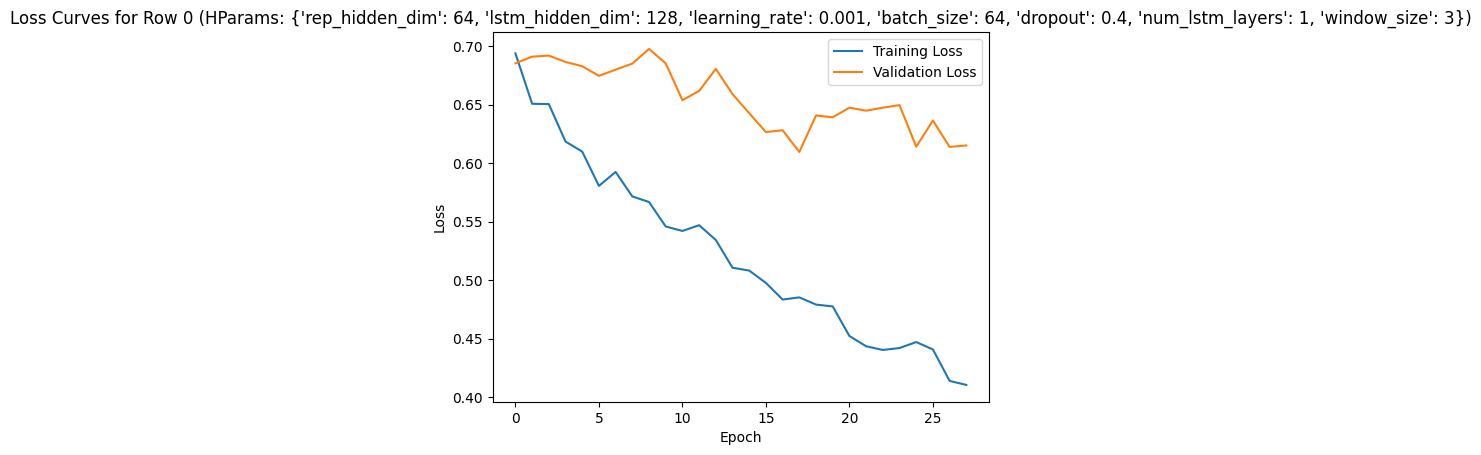

In [210]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_loss_curves_for_row(row_index, df):
    """Plots training and validation loss curves for a specific row in the DataFrame."""

    hparams = {  # Reconstruct the hparams dictionary from the row
        'rep_hidden_dim': df.loc[row_index, 'rep_hidden_dim'],
        'lstm_hidden_dim': df.loc[row_index, 'lstm_hidden_dim'],
        'learning_rate': df.loc[row_index, 'learning_rate'],
        'batch_size': df.loc[row_index, 'batch_size'],
        'dropout': df.loc[row_index, 'dropout'],
        'num_lstm_layers': df.loc[row_index, 'num_lstm_layers'],
        'window_size': df.loc[row_index, 'window_size']
    }

    train_losses = df.loc[row_index, 'best_train_losses']  # Assuming you stored them
    val_losses = df.loc[row_index, 'best_val_losses']  # Assuming you stored them

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curves for Row {row_index} (HParams: {hparams})')
    plt.show()

# Example usage:
df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)
plot_loss_curves_for_row(0, df)  # Plot loss curves for the first row (index 0)

In [211]:
def evaluate_on_test(row_index, df, save=False, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    # 1. Load best model weights from 'results'

    # Extract hyperparameters from the row:
    hparams = df.loc[row_index, ['rep_hidden_dim', 'lstm_hidden_dim', 'learning_rate', 'batch_size', 'dropout', 'num_lstm_layers', 'window_size', 'balance_ratio', 'near_failure_ratio']].to_dict()

    # Convert relevant hyperparameters to int:
    hparams['rep_hidden_dim'] = int(hparams['rep_hidden_dim'])
    hparams['lstm_hidden_dim'] = int(hparams['lstm_hidden_dim'])
    hparams['batch_size'] = int(hparams['batch_size'])
    hparams['num_lstm_layers'] = int(hparams['num_lstm_layers'])
    hparams['window_size'] = int(hparams['window_size'])  # Add window_size
    hparams['balance_ratio'] = float(hparams['balance_ratio'])
    hparams['near_failure_ratio'] = float(hparams['near_failure_ratio'])

    model_path = df.loc[row_index, 'best_model_state']

    # 2. Reconstruct a model with the same architecture/params used in training

    model = LSTMFailurePredictor(
        frame_dim=7,
        rep_hidden_dim=hparams['rep_hidden_dim'],
        lstm_hidden_dim=hparams['lstm_hidden_dim'],
        dropout=hparams['dropout'],
        num_lstm_layers=hparams['num_lstm_layers'],
        window_size=hparams['window_size']
    ).to(device)

    # 3. Load the weights

    buffer = io.BytesIO(model_path)
    best_model_state = torch.load(buffer)

    model.load_state_dict(best_model_state)
    model.eval()

    if save:
        torch.save(model.state_dict(), 'best_model.pth')



    # 4. Create DataLoader for test set
    test_dataset = SlidingWindowRepDataset(test_data, balance_ratio=hparams['balance_ratio'], near_failure_ratio=hparams['near_failure_ratio'])
    test_loader  = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False)

    # 5. Inference loop
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for reps, labels in test_loader:
            reps, labels = reps.to(device), labels.to(device)
            logits = model(reps)

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # 6. Compute your metrics
    pred_prob = torch.sigmoid(all_logits)
    pred = (pred_prob >= 0.5).long()

    # E.g., compute accuracy, precision, recall:
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    acc = accuracy_score(all_labels, pred)
    precision = precision_score(all_labels, pred, zero_division=0)
    recall = recall_score(all_labels, pred, zero_division=0)
    f1 = f1_score(all_labels, pred, zero_division=0)

    print("Test Accuracy:", f"{acc:.4f}")
    print("Test Precision:", f"{precision:.4f}")
    print("Test Recall:", f"{recall:.4f}")
    print("Test F1:", f"{f1:.4f}")



df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)

evaluate_on_test(0, df, save=False)

Test Accuracy: 0.7468
Test Precision: 0.7468
Test Recall: 0.7468
Test F1: 0.7468


In [212]:
from collections import defaultdict, deque

def evaluate_online_inference(row_index, df, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    """Evaluates online inference using a saved model and test data."""
    # 1. Load the model
    hparams = df.loc[row_index, ['rep_hidden_dim', 'lstm_hidden_dim', 'learning_rate', 'batch_size', 'dropout', 'num_lstm_layers', 'window_size']].to_dict()

    # Convert relevant hyperparameters to int:
    hparams['rep_hidden_dim'] = int(hparams['rep_hidden_dim'])
    hparams['lstm_hidden_dim'] = int(hparams['lstm_hidden_dim'])
    hparams['batch_size'] = int(hparams['batch_size'])
    hparams['num_lstm_layers'] = int(hparams['num_lstm_layers'])
    hparams['window_size'] = int(hparams['window_size'])  # Add window_size

    model_path = df.loc[row_index, 'best_model_state']

    # 2. Reconstruct a model with the same architecture/params used in training

    model = LSTMFailurePredictor(
        frame_dim=7,
        rep_hidden_dim=hparams['rep_hidden_dim'],
        lstm_hidden_dim=hparams['lstm_hidden_dim'],
        dropout=hparams['dropout'],
        num_lstm_layers=hparams['num_lstm_layers'],
        window_size=hparams['window_size']
    ).to(device)

    # 3. Load the weights

    buffer = io.BytesIO(model_path)
    best_model_state = torch.load(buffer)

    model.load_state_dict(best_model_state)
    model.eval()

    # 2. Prepare data and window
    window = deque(maxlen=hparams['window_size'])
    random_key = random.choice(list(test_data.keys()))
    incoming_reps = np.stack(test_data[random_key], axis=0)

    print(f"Video set: {random_key}")
    print("Total number of reps: ", len(incoming_reps))

    # 3. Online inference loop
    all_logits = []
    all_labels = []
    for t, rep in enumerate(incoming_reps):
        window.append(rep)

        if len(window) == hparams['window_size']:
            input_tensor = torch.tensor([list(window)], dtype=torch.float32).to(device)
            logit = model(input_tensor)
            prob = torch.sigmoid(logit).item()

            print(f"Rep {t}: P(fail) = {prob:.4f}")

            all_logits.append(logit.cpu().item())  # Store logit (not probability)
            all_labels.append(1 if t == len(incoming_reps) - 1 else 0)  # Label as failure only if it's the last rep

            if prob > 0.5:
                print(f"🔥 FAIL detected at rep {t}! Model stops.")
                break

    return all_logits, all_labels, random_key  # Return logits, labels, and video key


df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)

evaluate_online_inference(0, df)


Video set: IMG_6017.mp4_set_0
Total number of reps:  13
Rep 2: P(fail) = 0.3507
Rep 3: P(fail) = 0.4558
Rep 4: P(fail) = 0.2394
Rep 5: P(fail) = 0.5317
🔥 FAIL detected at rep 5! Model stops.


([-0.6161724925041199,
  -0.1771983951330185,
  -1.1561952829360962,
  0.12678304314613342],
 [0, 0, 0, 0],
 'IMG_6017.mp4_set_0')

In [214]:
import io
from collections import defaultdict, deque

def evaluate_distance_metrics(row_index, df, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    """Evaluates online inference using a saved model and test data."""
    # 1. Load the model
    hparams = df.loc[row_index, ['rep_hidden_dim', 'lstm_hidden_dim', 'learning_rate', 'batch_size', 'dropout', 'num_lstm_layers', 'window_size']].to_dict()

    # Convert relevant hyperparameters to int:
    hparams['rep_hidden_dim'] = int(hparams['rep_hidden_dim'])
    hparams['lstm_hidden_dim'] = int(hparams['lstm_hidden_dim'])
    hparams['batch_size'] = int(hparams['batch_size'])
    hparams['num_lstm_layers'] = int(hparams['num_lstm_layers'])
    hparams['window_size'] = int(hparams['window_size'])  # Add window_size




    # 2. Reconstruct a model with the same architecture/params used in training

    model = LSTMFailurePredictor(
        frame_dim=7,
        rep_hidden_dim=hparams['rep_hidden_dim'],
        lstm_hidden_dim=hparams['lstm_hidden_dim'],
        dropout=hparams['dropout'],
        num_lstm_layers=hparams['num_lstm_layers'],
        window_size=hparams['window_size']
    ).to(device)

    # 3. Load the weights

    model_path = df.loc[row_index, 'best_model_state']

    buffer = io.BytesIO(model_path)
    best_model_state = torch.load(buffer)

    model.load_state_dict(best_model_state)


    model.eval()

    distances = []

    with torch.no_grad():
        for key, list_of_reps in test_data.items():
            # Check if list_of_reps is empty
            if not list_of_reps:
                print(f"Skipping video '{key}' because it has no reps.")
                continue  # Skip to the next video

            reps = np.stack(list_of_reps, axis=0)  # shape (R, 10, frame_dim)
            R = reps.shape[0]

            # If we have fewer than 3 reps, skip because our model needs 3 for the first prediction
            if R < 3:
                continue

            window = deque(maxlen=3)
            predicted_fail_idx = None  # Will store the index where model first says "fail"

            for t in range(R):
                rep = reps[t]
                window.append(rep)

                # Only start predicting once we have a full window of 3
                if len(window) == 3:
                    input_tensor = torch.tensor([list(window)], dtype=torch.float32).to(device)  # Move to correct device

                    logit = model(input_tensor)
                    prob = torch.sigmoid(logit).item()

                    if prob > 0.5:
                        predicted_fail_idx = t
                        break

            # The *actual* fail is the last rep in this sequence
            actual_fail_idx = R - 1

            # Compute the difference (pred - actual). If no fail predicted, store a large penalty
            if predicted_fail_idx is not None:
                dist = predicted_fail_idx - actual_fail_idx
            else:
                dist = None  # No prediction made

            distances.append(dist)
    print("Distances:", distances)


    # Filter out any None distances (for sequences where no fail was predicted)
    valid_distances = [d for d in distances if d is not None]

    # Compute additional statistics if there are valid distances
    if len(valid_distances) > 0:
        mean_distance = np.mean(valid_distances)
        median_distance = np.median(valid_distances)
        std_dev_distance = np.std(valid_distances)
        min_distance = np.min(valid_distances)
        max_distance = np.max(valid_distances)

        print("\n📊 **Failure Prediction Metrics** 📊")
        print(f"➡ Mean Distance:  {mean_distance:.4f}")
        print(f"➡ Median Distance: {median_distance:.4f}")
        print(f"➡ Std Deviation:  {std_dev_distance:.4f}")
        print(f"➡ Min Distance:   {min_distance}")
        print(f"➡ Max Distance:   {max_distance}")
        print("(Negative => model predicted failure before actual fail)")
    else:
        print("No fail was ever predicted on the validation set (all predicted_fail_idx were None).")

df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)

evaluate_distance_metrics(0, df)


Distances: [-4, -30, -13, -9, -2, -11, -16, -5, -1, -10, -32, 0, -11, -12, -11, 0, 0, 0, -2, -11, -15, -10, 0, -1, 0, -11, -6, -13, 0, -5, -3, -10, 0, -19, -10, 0, -10, -22, 0, -7, 0, -7, -1, -18, 0, -12, 0, -20, -6, 0, None, -4, 0, -7, -13, 0, -6, -14, -18, 0, -2, 0, -11, -14, -1, -3, -5, -13, -9, -2, -5, -25, None, None, -5, -6, None, -5, -2]

📊 **Failure Prediction Metrics** 📊
➡ Mean Distance:  -7.4133
➡ Median Distance: -6.0000
➡ Std Deviation:  7.3577
➡ Min Distance:   -32
➡ Max Distance:   0
(Negative => model predicted failure before actual fail)
